## Data Science exam

You have the orders.csv file loaded below. This is synthetic data designed to simulate real-world problems.

Each row represents a purchase order from a single customer.

Here are the columns in this dataset:

* customerId: Unique identifier for the customer.
* date: Date of the order.
* value: Total dollar amount paid in the order.
* site: Indicates whether the order was placed through the website.
* discount: Dollar amount of the discount applied to the order.

*Note: The value column already includes the discount, so no further subtraction is needed.*

Rules:

* You may use any available resources except human assistance during this exam.
* You have 4 hours to submit this file with your solution.
* Add a written analysis at the end of each problem. This analysis should be 1 to 2 paragraphs, as if you were summarizing the results to a client.
* The entire exam must be completed in English.
* Your results, thought process, analysis, and code will all be evaluated in this exam.
* Ensure your code is well-organized and includes sufficient comments where necessary.


### Question 1

We call **empirical probability** the probability estimated by dividing the number of observed successes by the total number of trials, once we have a sufficiently large number of trials.

Calculate **empirical probabilities** and present them in a table in the following format. You should calculate a total of 144 (12 × 12) probabilities and report them in a table format similar to the one bellow.


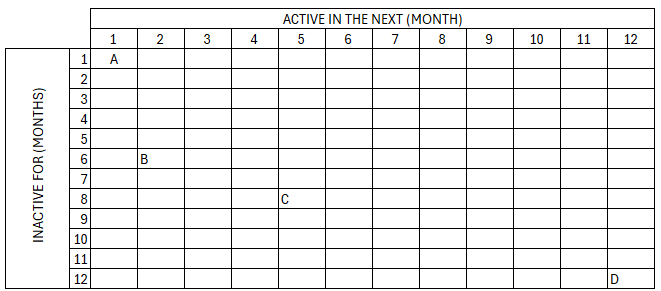

Definitions:

- **Inactive period**: A period of time with no orders.  
- **Active period**: A period of time with at least one order.

Cells A, B, C, and D are used as examples and explained below.

* *A: Probability of placing one or more orders in the **next month** after a **one-month inactivity** period.*
* *B: Probability of placing one or more orders in the **next two months** after **six-month inactivity** period.*
* *C: Probability of placing one or more orders in the **next five months** after **eight-month inactivity** period.*
* *D: Probability of placing one or more orders in the **next twelve months** after **twelve-month inactivity** period.*


In this problem, each inactivity period of one month or more for each costumer should be counted as a single event. For example, if a client is inactive for eight months, it counts as one 'eight-month inactivity period' event but does not count as 'one-month inactivity period' to 'seven-month inactivity period'.


In [1]:
import pandas as pd
import numpy as np
df = pd.read_parquet('orders.parquet')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287289 entries, 0 to 287288
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   customerId  287289 non-null  int64         
 1   date        287289 non-null  datetime64[ns]
 2   value       287289 non-null  float64       
 3   site        287289 non-null  bool          
 4   discount    287289 non-null  float64       
dtypes: bool(1), datetime64[ns](1), float64(2), int64(1)
memory usage: 9.0 MB


In [2]:
def check_cols(data, columns):
    df_check = pd.DataFrame(zip(data[columns].dtypes.index, 
                                data[columns].dtypes, 
                                data[columns].nunique(), 
                                data[columns].isna().sum(),
                                round(data[columns].isna().sum()/data.shape[0], 3)*100), 
                            columns=['Variável', 'Tipo', 'Qtde_unicos', 'Qtde_NaN', '%_NaN'])
    return df_check.sort_values('Qtde_NaN').reset_index().drop('index', axis=1)

check_cols(df, df.columns)

,Variável,Tipo,Qtde_unicos,Qtde_NaN,%_NaN
0,customerId,int64,1013,0,0.0
1,date,datetime64[ns],287289,0,0.0
2,value,float64,287289,0,0.0
3,site,bool,2,0,0.0
4,discount,float64,242607,0,0.0


In [3]:
df.head(5)

,customerId,date,value,site,discount
0,221958,2023-01-04 14:40:22.056403410,993.941415,False,29.934283
1,221958,2023-02-09 20:52:59.287576193,602.110247,False,17.234714
2,221958,2022-11-05 15:08:25.793837997,808.768855,True,34.123771
3,221958,2023-08-16 02:33:15.591873068,1188.652986,False,50.460597
4,221958,2023-10-17 00:06:22.968478075,651.454662,False,15.316933


In [4]:
customer_order_counts = df.groupby('customerId')['date'].count()

df = df.sort_values(by=['customerId', 'date'])

#periodos de inatividade 
df['prev_date'] = df.groupby('customerId')['date'].shift(1)
df['inactivity_months'] = ((df['date'] - df['prev_date']).dt.days / 30).fillna(0).astype(int)

#distribuicao
inactivity_distribution = df['inactivity_months'].value_counts().sort_index()

print('distribuicao de pedidos por cliente:')
print(customer_order_counts.describe())

print('\ndistribuicao dos períodos de inatividade:')
print(inactivity_distribution)


distribuicao de pedidos por cliente:
count    1013.000000
mean      283.602172
std       618.470984
min         1.000000
25%        23.000000
50%        83.000000
75%       274.000000
max      7730.000000
Name: date, dtype: float64

distribuicao dos períodos de inatividade:
inactivity_months
0     286811
1        408
2         35
3          8
4          4
5          1
6          4
7          5
8          3
10         1
11         1
12         1
13         1
14         2
15         1
20         1
22         1
24         1
Name: count, dtype: int64


As we can see, the behavior of this company's customers is varied, but not that much. We have the highest concentration of periods with 0 months of inactivity, some with 1 month and a sharp drop of more than 90% for the second month. The average number of orders is 283 per customer, but the standard deviation is high (618), which indicates the presence of outliers, as shown in the min (1 order) and max (7730 orders). This information will be important to evaluate the results of the matrix.

In [5]:
inactivity_counts = {i: {j: 0 for j in range(1, 13)} for i in range(1, 13)}
total_inactive = {i: 0 for i in range(1, 13)}

In [6]:
for customer, data in df.groupby('customerId'):
    previous_date = None
    for date in data['date']:
        if previous_date is not None:
            inactivity_months = (date.year - previous_date.year) * 12 + (date.month - previous_date.month)
            if inactivity_months >= 1 and inactivity_months <= 12:
                total_inactive[inactivity_months] += 1
                for active_months in range(1, 13):
                    if inactivity_months + active_months in total_inactive:
                        inactivity_counts[inactivity_months][active_months] += 1
        previous_date = date

In [7]:
probability_matrix = np.zeros((12, 12))

for i in range(1, 13):
    for j in range(1, 13):
        if total_inactive[i] > 0:
            probability_matrix[i-1, j-1] = inactivity_counts[i][j] / total_inactive[i]

In [8]:
probability_df = pd.DataFrame(probability_matrix, index=range(1, 13), columns=range(1, 13))
print(probability_df)

     1    2    3    4    5    6    7    8    9    10   11   12
1   1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0
2   1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0
3   1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0
4   1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0
5   1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0
6   1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
7   1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
8   1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
9   1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
10  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
11  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
12  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0


In this matrix, the statistical behavior of the base is revealed: the longer the period of inactivity, the lower the probability of the customer buying from us again. We can say that the probability of buying again follows a decreasing order as the period of inactivity increases. Customers with more than 9 months of inactivity rarely return. A major breakeven occurs after 6 months of inactivity, where the customer rarely returns to buy in the seventh month. All this information and probability serve to encourage marketing actions. In a churn model, this behavior is quite common (the longer the time away from the brand, the lower the probability of returning, logically depending on the product/service). Up until the 6th month, the actions to reactivate these customers tend to be more effective. After the seventh month, they may not be as fruitful, and after 10 months, we could officially declare this customer's churn.

## Question 2

Is there a trend where order values tend to increase or decrease as dates become more recent?

Tip: You can use a scatterplot and correlation analysis to help answer this question.

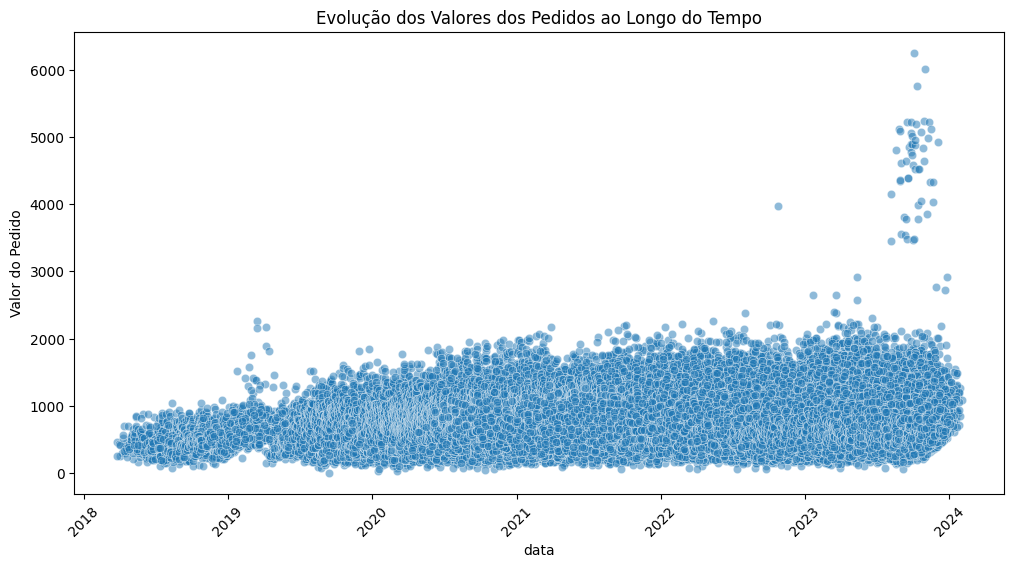

correlação entre data e valor do pedido: 0.2436


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))
sns.scatterplot(x=df['date'], y=df['value'], alpha=0.5)
plt.xlabel('data')
plt.ylabel('Valor do Pedido')
plt.title('Evolução dos Valores dos Pedidos ao Longo do Tempo')
plt.xticks(rotation=45)
plt.show()

# conversao da data para numerico para medir a correlacao
df['date_numeric'] = df['date'].astype('int64') 
correlation = df[['date_numeric', 'value']].corr().iloc[0,1]

print(f'correlação entre data e valor do pedido: {correlation:.4f}')


As you can see from the scatter plot, the values ​​are increasing over time, but the increase does not appear to be that significant. Let me explain: the increase does happen over time, but the total values ​​do not change that much, despite some outliers. The value of orders tends to increase over time, but they do not appear to make very large jumps, such as from 1 to 5. Most of the concentration of increases is between 1 and 2/2.5, so there is an increase, but it is not that far from the older values. This does not mean that customers are buying more, since the graph is displayed by year, so exogenous variables can explain this 'slight' increase. Inflation, exchange rate variation, price increases or changes in the product mix can be the reasons for this smooth increase in values ​​over time. 

Analysing some outliers:

In [10]:
#separando os quatis
Q1 = df['value'].quantile(0.25)
Q3 = df['value'].quantile(0.75)
#interquartile range
IQR = Q3 - Q1 

limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

outliers_df = df[(df['value'] < limite_inferior) | (df['value'] > limite_superior)]

In [11]:
print(outliers_df.sample(10))

        customerId                          date        value   site  \
173152      864757 2022-01-25 01:01:12.499243075  1539.443900   True   
56925       814016 2021-12-22 09:54:51.412945110  1489.735013  False   
79045       182989 2021-10-15 02:29:27.495050485  1586.087406  False   
90299       653020 2023-03-06 22:21:52.061179332  1347.201485  False   
256080      494070 2022-07-09 06:43:22.240958601  1361.511220  False   
171927      713157 2023-10-15 08:00:04.622299053  1378.175937  False   
277073      713157 2023-07-16 13:23:08.389384825  1724.870147  False   
1855        421879 2022-06-14 23:24:43.325479952  1426.341268   True   
139430      129402 2023-01-04 00:07:50.365381793  1361.787964  False   
188006      330229 2022-06-28 03:58:19.197510739  1695.576119  False   

         discount                     prev_date  inactivity_months  \
173152  34.894172 2022-01-24 05:45:43.590489989                  0   
56925   20.600595 2021-12-22 08:29:41.022144098                  0 

In [12]:
media_pedidos = df['value'].mean()
mediana_pedidos = df['value'].median()
max_pedidos = df['value'].max()

print(f'Média dos pedidos: {media_pedidos:.2f}')
print(f'Mediana dos pedidos: {mediana_pedidos:.2f}')
print(f'Maior pedido registrado: {max_pedidos:.2f}')

print(f'Média dos outliers: {outliers_df['value'].mean():.2f}')

Média dos pedidos: 720.01
Mediana dos pedidos: 689.86
Maior pedido registrado: 6255.69
Média dos outliers: 1538.76


All orders in the table have values ​​greater than 1k, which is above the average for orders: 720.01. We can also see that most of them (if not all, I didn't open the full table) have 0 months of inactivity. They are constant buyers who place high orders, loyal customers who can be categorized differently, depending on the product/service. Is it interesting for the business to have customers with this volume? Let's analyze the discounts.

In [13]:
correlacao_valor_desconto = df[['value', 'discount']].corr().iloc[0,1]
print(f'Correlação entre valor do pedido e desconto: {correlacao_valor_desconto:.4f}')


Correlação entre valor do pedido e desconto: 0.3669


The correlation between discounts and order value is close to a correlation that I would consider moderate. So discounts may be a big draw for these customers, but because the average order value of this outlier is almost double the average order value of other customers, it may not be the only factor that drives these customers to buy large volumes with such assiduity.

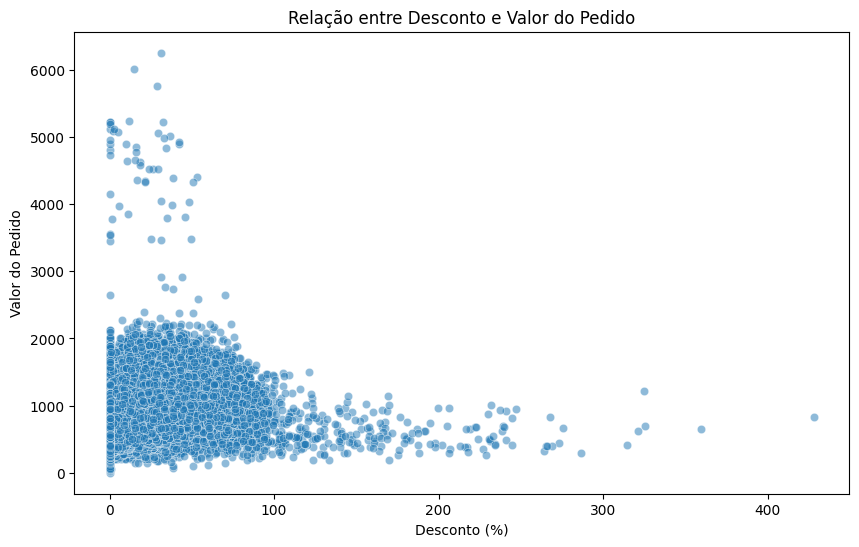

In [14]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=df['discount'], y=df['value'], alpha=0.5)
plt.xlabel('Desconto (%)')
plt.ylabel('Valor do Pedido')
plt.title('Relação entre Desconto e Valor do Pedido')
plt.show()


The graph represents the correlation described above: there is a correlation that tends to be moderate but not that strong. Therefore, other factors may impact these customer requests. There is a lack of information for a more in-depth analysis and suggested action on them.

## Question 3

Build a linear regression model using *date*, *discount*, and *site* as predictors to estimate *value*.  You may apply any necessary data transformations to improve model performance.

1. **Train-Test Split & RMSE Calculation**  
   - Use a 70-30 train-test split.  
   - Justify the best approach for splitting the data.  
   - Calculate and report the Root Mean Squared Error (RMSE).  

2. **Interpretation of Coefficients & P-Values**  
   - Identify the most important predictors.  
   - Interpret their coefficients and p-values.  

3. **Model Evaluation**  
   - Assess the model’s overall performance.  
   - Explain how you evaluate its accuracy and reliability.  

4. **Residual Analysis**  
   - Plot relevant charts to analyze residuals.  

5. **Model Issues**  
   - Identify and explain at least two major problems with the model.


*Note: This dataset will not allow you to build a model with all the ideal properties typically found in textbooks. It is synthetic data designed to represent a real-world problem, and the available predictors are not sufficient to create a highly accurate model. The objective of this question is to assess your reasoning and approach when dealing with particularly challenging problems.*

Dividirei o dataset em Treino-Teste-Validacao, abordagem segura que mais utilizo nos meus modelos.
Treino (60%) → O modelo aprende a relação entre as variáveis.
Teste (20%) → Usado para ajustar hiperparâmetros e evitar overfitting.
Validação (20%) → Mede o desempenho real do modelo em dados nunca vistos.

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

df['date_numeric'] = df['date'].astype('int64') // 10**9  # formato padrão do pandas é nanosegundos, dividimos por 10⁹ para converter para segundos, reduzindo a escala para um tamanho mais adequado ao modelo

# bool
df['site'] = df['site'].astype(int)

# variáveis preditoras e a variável alvo
X = df[['date_numeric', 'discount', 'site']]
y = df['value']

In [19]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)  # 40% temporário
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # 20% cada

modelo = LinearRegression()
modelo.fit(X_train, y_train)

# previsões e avaliação do modelo
y_pred_test = modelo.predict(X_test)
y_pred_val = modelo.predict(X_val)
# avaliacao das medidas 
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))
print(f'Root Mean Squared Error (RMSE) - Teste: {rmse_test:.2f}')
print(f'Root Mean Squared Error (RMSE) - Validação: {rmse_val:.2f}')

#r2 para explicacaoi do modelo
r2_test = modelo.score(X_test, y_test)
r2_val = modelo.score(X_val, y_val)
print(f'R² do modelo - Teste: {r2_test:.4f}')
print(f'R² do modelo - Validação: {r2_val:.4f}')


Root Mean Squared Error (RMSE) - Teste: 228.00
Root Mean Squared Error (RMSE) - Validação: 224.26
R² do modelo - Teste: 0.1867
R² do modelo - Validação: 0.1841


Both results are very close, whether in testing or validation. This indicates that the model tends to generalize well on unseen data as well, however, the R2 indicates that the model's predictors are not sufficient, since with this data we can only explain 18%.

In [41]:
X_train_sm = sm.add_constant(X_train) 
modelo_sm = sm.OLS(y_train, X_train_sm).fit()
print(modelo_sm.summary())

                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.187
Model:                            OLS   Adj. R-squared:                  0.187
Method:                 Least Squares   F-statistic:                 1.321e+04
Date:                Wed, 26 Feb 2025   Prob (F-statistic):               0.00
Time:                        17:32:08   Log-Likelihood:            -1.1784e+06
No. Observations:              172373   AIC:                         2.357e+06
Df Residuals:                  172369   BIC:                         2.357e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -1849.9838     24.218    -76.390   

Analyzing the model's statistics, we have some problems: the very low explanatory power, the negative intercept that indicates that the model extrapolates poorly to older values, which may indicate the need to transform the variables (data_numeric), for example.

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# df com aas variáveis preditoras e adicionar a constante
X_vif = sm.add_constant(X_train)

#VIF para cada variável
vif_data = pd.DataFrame()
vif_data['Variável'] = X_vif.columns
vif_data['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

print('Variance Inflation Factor (VIF):')
print(vif_data)

Variance Inflation Factor (VIF):
       Variável       VIF
0         const  0.000000
1  date_numeric  1.013388
2      discount  1.003052
3          site  1.010322


/mnt/c/Users/Loading Error/Desktop/teste ds/.venv/lib/python3.12/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


We can see here that multicollinearity is not the problem with this model, since all of them are below 5. More variables would most likely help.

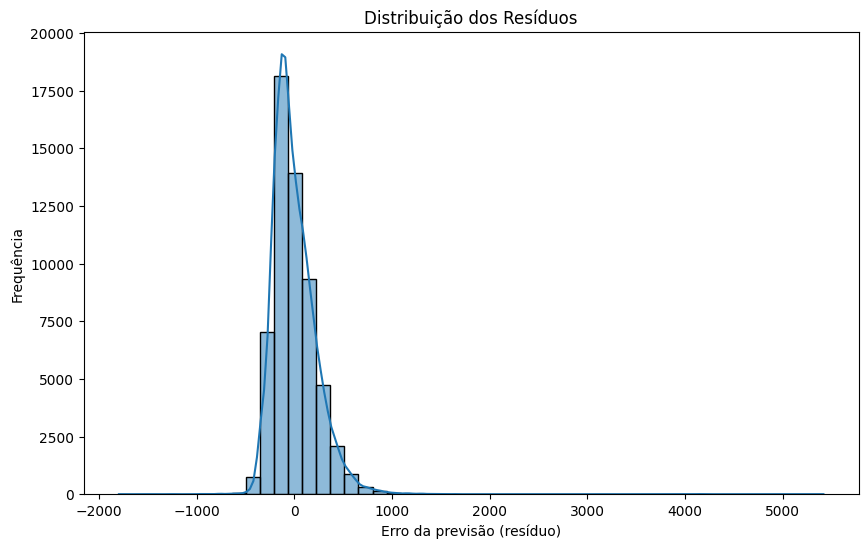

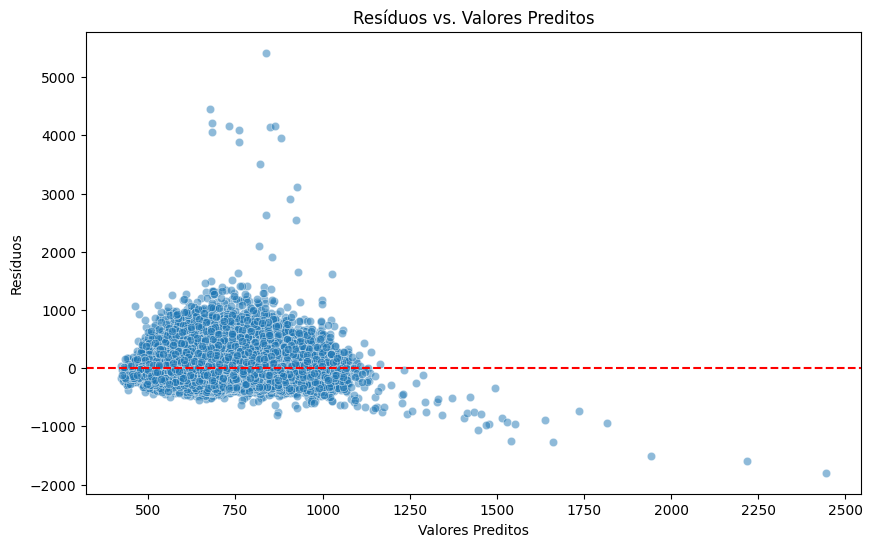

In [21]:
# analise dos residuos
residuos = y_test - y_pred_test

plt.figure(figsize=(10,6))
sns.histplot(residuos, bins=50, kde=True)
plt.xlabel('Erro da previsão (resíduo)')
plt.ylabel('Frequência')
plt.title('Distribuição dos Resíduos')
plt.show()

plt.figure(figsize=(10,6))
sns.scatterplot(x=y_pred_test, y=residuos, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Valores Preditos')
plt.ylabel('Resíduos')
plt.title('Resíduos vs. Valores Preditos')
plt.show()

In [ ]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from scipy.stats import anderson

# residuos do modelo
X_train_sm = sm.add_constant(X_train)  
modelo_sm = sm.OLS(y_train, X_train_sm).fit()
residuos = modelo_sm.resid

# Breusch-Pagan para heterocedasticidade
bp_test = het_breuschpagan(residuos, X_train_sm)
print(f'Breusch-Pagan Test:')
print(f'   Estatística: {bp_test[0]:.4f}')
print(f'   P-valor: {bp_test[1]:.4f}')
if bp_test[1] < 0.05:
    print(' Há heterocedasticidade (violação da regressão linear).')
else:
    print(' Os erros têm variância constante (bom para regressão linear).')

#Anderson-Darling para normalidade dos resíduos
ad_test = anderson(residuos)
print('\nAnderson-Darling Test:')
print(f'   Estatística: {ad_test.statistic:.4f}')
for i in range(len(ad_test.critical_values)):
    significance_level = ad_test.significance_level[i]
    critical_value = ad_test.critical_values[i]
    if ad_test.statistic > critical_value:
        print(f'No nível de {significance_level}% de significância, os resíduos NÃO são normais.')
    else:
        print(f' No nível de {significance_level}% de significância, os resíduos são normais.')


Breusch-Pagan Test:
   Estatística: 407.1124
   P-valor: 0.0000
 Há heterocedasticidade (violação da regressão linear).

Anderson-Darling Test:
   Estatística: 2267.4393
No nível de 15.0% de significância, os resíduos NÃO são normais.
No nível de 10.0% de significância, os resíduos NÃO são normais.
No nível de 5.0% de significância, os resíduos NÃO são normais.
No nível de 2.5% de significância, os resíduos NÃO são normais.
No nível de 1.0% de significância, os resíduos NÃO são normais.


As can be seen from the statistical tests, there is heteroscedasticity in the linear regression, which violates one of the principles for a correct linear regression, and the residuals do not present normality, which affects statistical inferences and model predictions. Ideally, you should have a little more time to run the tests correctly and choose the appropriate approach for the problem. :)